# Reading and training tom and jerry dataset from kaggle

## Imports and definations

### Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, random_split

import torchvision

from pathlib import Path

from matplotlib import pyplot as plt

### functions

In [24]:
def train(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: str = 'cuda'):
    number_of_batches = len(data_loader)
    model.train()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        if (i % 10 == 0) or i == number_of_batches-1:
            print(f'\r{i+1}/{number_of_batches}, loss = {loss.item():>4f}',end='')
    print()

In [3]:
def test(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, device:str='cuda') -> (torch.float, torch.float):
    data_size = len(data_loader.dataset)
    number_of_batches = len(data_loader)

    model.eval()

    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) ==
                        labels).type(torch.float).sum().item()

        loss /= number_of_batches
        correct /= data_size

    return correct, loss

## Run

### device

In [4]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device ='mps'

print(f'device: {device}')

device: cuda


### get data

#### In pc

In [5]:
data_path = Path(
    '/home/ramin/ramin_programs/files/datasets/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry')

#### In colab

In [3]:
from google.colab import userdata

In [4]:
kaggle_target_path = Path('/root/.kaggle/kaggle.json')

kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

with open(kaggle_target_path,'w') as f:
  f.write(userdata.get('Kaggle'))

In [5]:
! kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

100% 433M/435M [00:22<00:00, 22.9MB/s]
100% 435M/435M [00:22<00:00, 20.1MB/s]


In [6]:
! unzip -q tom-and-jerry-image-classification

In [7]:
! rm -r tom-and-jerry-image-classification.zip

In [8]:
data_path = Path('tom_and_jerry/tom_and_jerry')

### load data

In [6]:
tr = torchvision.transforms.Compose(
    [torchvision.transforms.Resize([90,160]),torchvision.transforms.ToTensor(),]
)

image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)

In [7]:
g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(
    image_folder, [0.6, 0.2, 0.2], g1)

In [8]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True)

tensor(2)


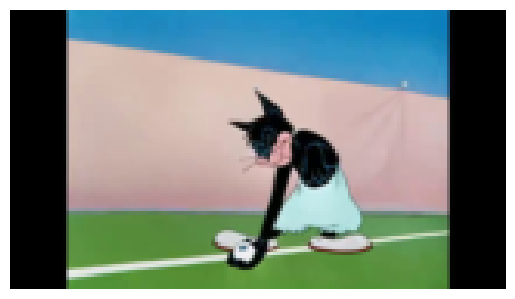

In [9]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

### define model

In [19]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)

In [20]:
model.classifier[1] = nn.Linear(1280,4)

In [21]:
model = model.to(device)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

### train the model

In [25]:
for epoch in range(5):
    print(f'in epoch: {epoch}')
    train(model, train_data_loader, loss_fn,
          optimizer, device)
    accuracy, loss = test(model, val_data_loader, loss_fn, device)
    print(f'accuracy: {accuracy:.2f}, loss: {loss:.2f}')

in epoch: 0
103/103, loss = 0.314396
accuracy: 0.83, loss: 0.46
in epoch: 1
103/103, loss = 0.208117
accuracy: 0.87, loss: 0.38
in epoch: 2
103/103, loss = 0.091612
accuracy: 0.89, loss: 0.34
in epoch: 3
103/103, loss = 0.520415
accuracy: 0.80, loss: 0.77
in epoch: 4
103/103, loss = 0.120538
accuracy: 0.89, loss: 0.38


In [26]:
accuracy, loss = test(model, test_data_loader, loss_fn, device)
print('test results:')
print(f'accuracy: {accuracy}, loss: {loss}')

test results:
accuracy: 0.8876712328767123, loss: 0.37545181789568494
